# Iterators

My favorite "feature" of pandas is that it's written in Python.
Python has great language-level features for handling streams of text
that don't nescessarily fit in memory.

In [3]:
%matplotlib inline

import os
import gzip
from itertools import islice, takewhile

import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
from toolz import partition_all, partitionby
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10

In [15]:
HEADER = 512
with gzip.open("data/beeradvocate.tar.gz", "r") as f:
    f.seek(HEADER)
    print(f.read(1500).decode('utf-8'))

beer/name: Sausa Weizen
beer/beerId: 47986
beer/brewerId: 10325
beer/ABV: 5.00
beer/style: Hefeweizen
review/appearance: 2.5
review/aroma: 2
review/palate: 1.5
review/taste: 1.5
review/overall: 1.5
review/time: 1234817823
review/profileName: stcules
review/text: A lot of foam. But a lot.	In the smell some banana, and then lactic and tart. Not a good start.	Quite dark orange in color, with a lively carbonation (now visible, under the foam).	Again tending to lactic sourness.	Same for the taste. With some yeast and banana.		

beer/name: Red Moon
beer/beerId: 48213
beer/brewerId: 10325
beer/ABV: 6.20
beer/style: English Strong Ale
review/appearance: 3
review/aroma: 2.5
review/palate: 3
review/taste: 3
review/overall: 3
review/time: 1235915097
review/profileName: stcules
review/text: Dark red color, light beige foam, average.	In the smell malt and caramel, not really light.	Again malt and caramel in the taste, not bad in the end.	Maybe a note of honey in teh back, and a light fruitiness.	Av

This is a dataset on beer reviews from beeradvocate.com.
It's a plaintext file where

- Reviews are separated by blank lines (i.e. the line is just `'\n'`)
- Each field of a review is its own line formated like `meta/field: value`

Pandas can't read this file natively, but we have Python!

## Developing a solution

In [48]:
f = gzip.open("data/beeradvocate.tar.gz", "rt")
f.seek(0)
f.seek(HEADER)

512

We can't just read in the entire file into memory.
Let's grab the first review using `takewhile` till the first `'\n'`

In [18]:
from itertools import takewhile

In [19]:
takewhile?

In [50]:
first = list(takewhile(lambda x: x != '\n', f))
first

['beer/name: Sausa Weizen\n',
 'beer/beerId: 47986\n',
 'beer/brewerId: 10325\n',
 'beer/ABV: 5.00\n',
 'beer/style: Hefeweizen\n',
 'review/appearance: 2.5\n',
 'review/aroma: 2\n',
 'review/palate: 1.5\n',
 'review/taste: 1.5\n',
 'review/overall: 1.5\n',
 'review/time: 1234817823\n',
 'review/profileName: stcules\n',
 'review/text: A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.\t\t\n']

That's essentially a dictionary, but we need to split they keys and values, cleanup some line endings.

In [67]:
r = dict([x.strip('\n').split(": ", 1) for x in first])
r

{'beer/ABV': '5.00',
 'beer/beerId': '47986',
 'beer/brewerId': '10325',
 'beer/name': 'Sausa Weizen',
 'beer/style': 'Hefeweizen',
 'review/appearance': '2.5',
 'review/aroma': '2',
 'review/overall': '1.5',
 'review/palate': '1.5',
 'review/profileName': 'stcules',
 'review/taste': '1.5',
 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.\t\t',
 'review/time': '1234817823'}

Notice that optional argument to split; If a review had contained a literal `': '`, we'd be in trouble without limiting the split to just 1.

In [59]:
'review/text: Why I love beer: 1. '.split(': ', 1)

['review/text', 'Why I love beer: 1. ']

Lets wrap that up into a function `format_review`

In [65]:
def format_review(review):
    return dict(map(lambda x: x.strip('\n').split(": ", 1), review))

Assuming we've processed many reviews into a list, we'll then build op a DataFrame.

We have a bit of dtype work to do:

In [73]:
col_names = {
    'beer/ABV': 'abv',
    'beer/beerId': 'beer_id',
    'beer/brewerId': 'brewer_id',
    'beer/name': 'beer_name',
    'beer/style': 'beer_style',
    'review/appearance': 'review_appearance',
    'review/aroma': 'review_aroma',
    'review/overall': 'review_overall',
    'review/palate': 'review_palate',
    'review/profileName': 'profile_name',
    'review/taste': 'review_taste',
    'review/text': 'text',
    'review/time': 'time'
}
df = pd.DataFrame([r])
numeric = ['abv', 'review_appearance', 'review_aroma',
           'review_overall', 'review_palate', 'review_taste']
df = (df.rename(columns=col_names)
        .replace('', np.nan))
df[numeric] = df[numeric].astype(float)
df['time'] = pd.to_datetime(df.time.astype(int), unit='s')
df

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot.\tIn the smell some b...,2009-02-16 20:57:03


Writing that as a function:

In [75]:
def as_dataframe(reviews):
    col_names = {
        'beer/ABV': 'abv',
        'beer/beerId': 'beer_id',
        'beer/brewerId': 'brewer_id',
        'beer/name': 'beer_name',
        'beer/style': 'beer_style',
        'review/appearance': 'review_appearance',
        'review/aroma': 'review_aroma',
        'review/overall': 'review_overall',
        'review/palate': 'review_palate',
        'review/profileName': 'profile_name',
        'review/taste': 'review_taste',
        'review/text': 'text',
        'review/time': 'time'
    }
    df = pd.DataFrame(list(reviews))
    numeric = ['abv', 'review_appearance', 'review_aroma',
               'review_overall', 'review_palate', 'review_taste']
    df = (df.rename(columns=col_names)
            .replace('', np.nan))
    df[numeric] = df[numeric].astype(float)
    df['time'] = pd.to_datetime(df.time.astype(int), unit='s')
    return df

And now we can process the files; We'll get a handle for the full dataset, and stream chunks through our little pipeline of

1. split reviews on `'\n'`
2. pipe lines through `format_review`, returning a review
3. pipe lists of reviews through `as_dataframe`

In [76]:
(x for x in f)

<generator object <genexpr> at 0x111072728>

```python
with gzip.open("data/beeradvocate.tar.gz", "rt") as f:
    f.seek(HEADER)
    lines = (x for x in f if not x.startswith('\x00'))
    review_lines = filter(lambda x: x != ('\n',),
                          partitionby(lambda x: x == '\n', lines))
    reviews = (format_review(x) for x in review_lines)
    chunks = partition_all(100000, reviews)

    dfs = (as_dataframe(chunk) for chunk in chunks)
    os.makedirs("data/beer/", exist_ok=True)

    for i, df in enumerate(dfs):
        df.to_csv("data/beer/chunk_%s.csv.gz" % i, index=False,
                  compression="gzip")
        print(i)
```

In [5]:
!ls data/

cpi.csv           games.csv         ny-flights.csv.gz
flights.csv.zip   gdp.csv           subset.csv.gz


# Using Dask

The row order in the raw file seemed to be random. I wanted to grab
out an interesting subset: All reviews by the top 750 reviewers.

Again, we have the problem that the dataset doesn't quite fit in memory.
We could manually loop through the list of CSVs, keeping track of the count
of reviews per reviewer, manually freeing the memory after finishing that
CSV, but we'll let dask do it for us.

In [78]:
import dask.dataframe as dd

from dask.diagnostics import ResourceProfiler, ProgressBar
prof = ResourceProfiler()
pbar = ProgressBar()

In [83]:
# read in df, note that it's `dd.read_csv`
df = dd.read_csv("data/beer/*.csv.gz", blocksize=None, parse_dates=['time'],
                 compression='gzip')
df

dd.DataFrame<from-de..., npartitions=17>

Haven't actually done anything yet; Just collected some metadata.

Now let's get the counts.

In [86]:
vc = df.profile_name.value_counts()
vc

dd.Series<value-c..., npartitions=1>

Well, we still haven't done anything; Need to actually call `.compute` to trigger that.

In [87]:
with pbar, prof:
    profiles = vc.compute().index[:750]

[########################################] | 100% Completed | 29.2s


In [91]:
profiles

Index(['northyorksammy', 'BuckeyeNation', 'NeroFiddled', 'feloniousmonk',
       'mikesgroove', 'oberon', 'Gusler', 'WesWes', 'Jason', 'Bighuge',
       ...
       'GRPunk', 'shand', 'Minkybut', 'JamnesCameron', 'brownbeer', 'gmfessen',
       'JRed', 'ColdPoncho', 'Gosox8787', 'Vonerichs'],
      dtype='object', length=750)

In [88]:
prof.visualize();

In [89]:
with prof, pbar:
    sdf = df[df.profile_name.isin(profiles)].compute()

[########################################] | 100% Completed | 30.3s


In [90]:
len(sdf)

852610

```python
sdf.sort_values('time').head(100000).to_csv(
    "data/beer/subset.csv.gz", compression="gzip")
```

In [34]:
%xdel sdf

# Aside: Python & Parallelism

Python has a slightly complicated concurrency & parallelism story.
The first thing you'll hear is that, "Python has a GIL, so you should never use threads".

The GIL, or "Global Interpreter Lock", is a CPython implementation detail that makes you writing CPython itself easier. The general idea is that only one thread touching *python* objects can run at a time. [David Beazley](http://www.dabeaz.com/GIL/) is the person to listen to on this subject.
You can end up with the strange case where adding threads actually slows down the computation.

The usual answer among python programmers is to use MultiProcessing. Oversimplifying again, this essentailly starts a new python interpreter, serializes and copys all the objects in your runtime, and starts the task. Any results are serialized and sent back to the main processes. It's that serialization overhead that can be prohibitively costly for scientific python. We'd much prefer the shared-memory parallelism offered by threads.

Fortunately for us, a lot of the scientific stack is written in C or Fortran. Above, I noted that the GIL only applies to *python* objects. A library using compiled extensions *can* release the GIL. Anthing built on top of

- NumPy
- SciPy
- Numba (if requested)
- scikit-learn
- scikit-image
- pandas*
 
Will have be able to use threads just fine. The asterisk is there for pandas because not bit of C code releases the GIL. Thanks to Jeff Reback's work, (at the prompting of Matthew Rocklin, who has [written about this](http://matthewrocklin.com/blog/work/2015/03/10/PyData-GIL)). A rough list includes

- groupby
- nsmallest
- value_counts
- factorize (used in Groupby)
- Some datetime operations
- parts of read_csv

For the most part, you as a user don't have anything to worry about. Just use dask, and you'll get shared-memory parallelism for free.

In [7]:
df = pd.read_csv("data/subset.csv.gz", compression="gzip",
                 parse_dates=['time'])
df.head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,5.3,93,33,Steel Rail Extra Pale Ale,American Pale Ale (APA),3.5,3.5,4.0,4.0,Todd,4.0,"Presentation: Pint size, on tap from the Easts...",1996-08-22 00:00:01
1,17.5,111,35,Samuel Adams Triple Bock,American Strong Ale,3.0,4.0,4.0,4.5,Todd,4.5,Presentation: 8.45oz blue bottle with gold let...,1998-01-10 00:00:01
2,NaN,110,35,Samuel Adams Cream Ale,Cream Ale,4.5,4.0,4.5,4.0,Jason,4.5,Presentation: Pint. On tap at the Samuel Adams...,1998-01-28 00:00:01
3,5.2,148,45,Brooklyn Lager,American Amber / Red Lager,3.0,2.5,4.0,3.5,Todd,3.5,Presentation: 12 oz. brown bottle with a clear...,1998-02-11 00:00:01
4,5.6,325,100,McNeill's Firehouse Amber Ale,American Amber / Red Ale,3.5,3.5,4.0,3.5,Todd,4.0,Presentation: An old picture of firehouse with...,1998-02-14 00:00:01


In [10]:
df.profile_name.value_counts()

Gusler           1949
NeroFiddled      1702
feloniousmonk    1677
Jason            1616
francisweizen    1485
                 ... 
IronDjinn         437
edchicma          431
Crosling          418
BeerManDan        415
Tballz420         408
Name: profile_name, dtype: int64

# Aside: Namespaces

Pandas has been expanding its use of namespaces (or accessors) on `DataFrame` to group together related methods. This also limits the number of methods direclty attached to `DataFrame` itself, which can be overwhelming.

Currently, we have these namespaces:

- `.str`: defined on `Series` and `Index`es containing strings (object dtype)
- `.dt`: defined on `Series` with `datetime` or `timedelta` dtype
- `.cat`: defined on `Series` and `Indexes` with `category` dtype
- `.plot`: defined on `Series` and `DataFrames`

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Make a barplot of the count of reviews by hour of the day.

- Hint: Use the `.dt` namespace to get the `hour` component of a `datetime`
- Use the `.plot` namespace to get a `bar` chart

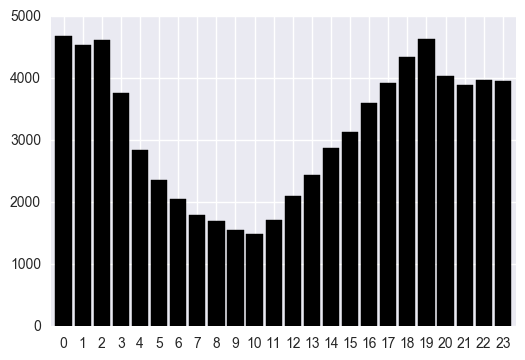

In [11]:
df.time.dt.hour.value_counts().sort_index().plot.bar(color='black', width=.85, rot=0);

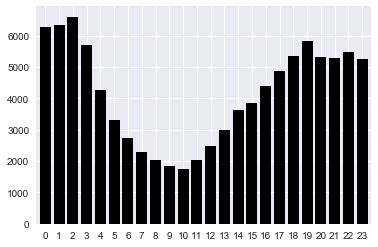

In [61]:
%load solutions/groupby_03.py

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Make a variable `pale_ales` that filters `df` to just rows containing `'pale ale'` (ignoring case)

In [14]:
pale_ales = df.beer_style.str.lower().str.contains('pale ale')
df.loc[pale_ales]

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,5.3,93,33,Steel Rail Extra Pale Ale,American Pale Ale (APA),3.5,3.5,4.0,4.0,Todd,4.0,"Presentation: Pint size, on tap from the Easts...",1996-08-22 00:00:01
5,5.5,324,100,McNeill's Champ Ale,American Pale Ale (APA),4.0,3.5,4.0,3.0,Todd,3.5,Presentation: 12 oz. bottle. Another story on ...,1998-02-17 00:00:01
11,5.0,264,6994,Alexander Keith's India Pale Ale,English India Pale Ale (IPA),2.5,2.5,4.0,3.0,Todd,2.5,"Presentation: 12oz brown twisty, with a red st...",1998-04-16 00:00:01
17,7.6,411,112,Pranqster,Belgian Strong Pale Ale,4.0,4.0,5.0,5.0,Todd,5.0,Presentation: 12oz fat twisty with a black&whi...,1998-06-01 00:00:01
30,5.5,6900,495,Nor'Wester Oregon Pale Ale,American Pale Ale (APA),4.0,4.5,4.0,4.0,Jason,4.5,Copper colour on the light side with a decent ...,1998-08-16 09:35:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75951,NaN,24029,1154,Willoughby Extra Pale Belgian Ale,Belgian Pale Ale,3.5,3.0,4.0,3.5,Dogbrick,3.0,On draught at 69 Taps in Akron. Lightly-hazed ...,2005-06-01 02:58:21
75956,5.0,5653,2210,Double Barrel Ale,English Pale Ale,4.0,4.0,4.0,3.5,BuckeyeNation,4.0,Bright coppery orange with maize colored accen...,2005-06-01 13:47:58
75977,NaN,17662,2423,Pale Ale,American Pale Ale (APA),4.0,3.0,4.0,3.5,bditty187,4.0,"Chill-haze, coppery-gold in hue, I think, the ...",2005-06-01 18:34:12
76002,5.0,2993,932,Hale's Moss Bay Extra,American Pale Ale (APA),4.5,4.5,4.0,4.0,WesWes,4.0,The beer pours a ruby red color with a thick f...,2005-06-01 23:39:18


In [65]:
%load solutions/groupby_04.py

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
64529,5.3,93,33,Steel Rail Extra Pale Ale,American Pale Ale (APA),3.5,3.5,4.0,4.0,Todd,4.0,"Presentation: Pint size, on tap from the Easts...",1996-08-22 00:00:01
26093,6.8,147,45,Brooklyn East India Pale Ale,English India Pale Ale (IPA),3.0,4.0,3.0,3.0,BeerAdvocate,3.0,Presentation: The Brooklyn Brewery style logo ...,1998-02-14 00:00:01
27201,5.0,264,6994,Alexander Keith's India Pale Ale,English India Pale Ale (IPA),2.5,2.5,4.0,3.0,Todd,2.5,"Presentation: 12oz brown twisty, with a red st...",1998-04-16 00:00:01
29695,4.5,302,138,India Pale Ale,English India Pale Ale (IPA),3.5,3.5,3.5,3.0,BeerAdvocate,4.0,Presentation: 12oz. clear bottle (wide w/thin ...,1998-04-23 00:00:01
21013,5.4,186,141,Smuttynose Shoals Pale Ale,American Pale Ale (APA),3.0,3.5,4.0,4.0,BeerAdvocate,4.0,Presentation: 12 oz bottle with a picture of t...,1998-05-05 00:00:01


## Groupby

Comes up in a lot of contexts. At its root it's about doing an operation on many subsets of the data, each of which shares something in common.
The components of a groupby operation are:

1. Split a table into groups
2. Apply a function to each group
3. Combine the results into a single DataFrame or Series

In pandas the first step looks like

```python
df.groupby( grouper )
```

`grouper` can be many things

- Series (or string indicating a column in `df`)
- function (to be applied on the index)
- dict : groups by *values*
- `levels=[ names of levels in a MultiIndex ]`

### 1. split

In [30]:
gr = df.groupby("beer_name")
gr

We haven't really done any actual work yet, but pandas knows what it needs to know to break the larger `df` into many smaller pieces, one for each distinct `beer_name`.

In [31]:
review_cols = ['review_appearance', 'review_aroma', 'review_overall',
               'review_palate', 'review_taste']
df.groupby('beer_name')[review_cols].agg('mean')

,review_appearance,review_aroma,review_overall,review_palate,review_taste
beer_name,,,,,
"""50"" Golden Anniversary Lager",5.000000,3.500000,4.000000,3.500000,3.500000
"""Alt""ered State",4.000000,3.750000,3.500000,4.000000,4.000000
"""Double Wrecked Wreck"" IPA",3.250000,3.750000,4.000000,4.000000,3.750000
"""Marnie"" Gras Carnival Ale",3.666667,4.333333,3.833333,4.000000,4.000000
"""Old Yeltsin"" Imperial Stout",4.176471,4.088235,3.676471,3.882353,3.970588
...,...,...,...,...,...
Öko Ur-Weizen,3.750000,4.000000,3.500000,3.250000,3.500000
Öko Urtrunk,4.000000,4.000000,4.500000,4.000000,4.000000
Ölsch,4.000000,4.000000,4.500000,4.000000,4.500000


<div class="alert alert-success">
    <b>Exercise</b> Find the `beer_style`s with the greatest variance in `abv`.
</div>

- hint: `.std` calculates the standard deviation, and is available on `GroupBy` objects like `gr.abv`.
- hint: use `.sort_values` to sort a Series by the values (it took us a while to come up with that name)

In [32]:
# TODO
gr.abv.std().sort_values().dropna()

beer_name
"Alt"ered State          0.000000
Pax Lager                0.000000
Pauwel Kwak              0.000000
Paulaner Roggen          0.000000
Paulaner Premium Pils    0.000000
                           ...   
Santa's Little Helper    1.745874
Framboise                1.767767
Anniversary Ale          2.325009
Dopplebock               2.381806
Belgian Ale              3.111270
Name: abv, dtype: float64

In this case, the three parts were:

- Split: `beer_name`
- Apply: `'mean'`
- Combine: `agg => 1 row per group`

Let's start with `.agg` since it's the most common in my experience.

Many Combinations:

- Grouper: Controls the output index
  * single grouper -> Index
  * array-like grouper -> MultiIndex
- Subject (Groupee): Controls the output data values
  * single column -> Series (or DataFrame if multiple aggregations)
  * multiple columns -> DataFrame
- Aggregation: Controls the output columns
  * single aggfunc -> Index in the colums
  * multiple aggfuncs -> MultiIndex in the columns (Or 1-D Index if groupee is 1-D)

In [33]:
# single grouper, single groupee, single aggregation
df.groupby('beer_style').review_overall.agg('mean')

beer_style
Altbier                       3.844017
American Adjunct Lager        2.708166
American Amber / Red Ale      3.741607
American Amber / Red Lager    3.455166
American Barleywine           4.005499
                                ...   
Vienna Lager                  3.697218
Weizenbock                    4.040816
Wheatwine                     4.013514
Winter Warmer                 3.792023
Witbier                       3.886922
Name: review_overall, dtype: float64

In [34]:
# single grouper, single groupee, multiple aggregations
df.groupby('beer_style').review_overall.agg(['min', 'max'])

,min,max
beer_style,,
Altbier,1.0,5.0
American Adjunct Lager,1.0,5.0
American Amber / Red Ale,0.0,5.0
American Amber / Red Lager,1.0,5.0
American Barleywine,1.0,5.0
...,...,...
Vienna Lager,1.0,5.0
Weizenbock,1.5,5.0
Wheatwine,2.5,5.0


In [35]:
# single grouper, array-like groupee, single aggregations
df.groupby('beer_style')['review_overall', 'review_aroma'].agg('mean')

,review_overall,review_aroma
beer_style,,
Altbier,3.844017,3.652422
American Adjunct Lager,2.708166,2.388666
American Amber / Red Ale,3.741607,3.589329
American Amber / Red Lager,3.455166,3.213450
American Barleywine,4.005499,4.111155
...,...,...
Vienna Lager,3.697218,3.417349
Weizenbock,4.040816,4.071429
Wheatwine,4.013514,4.054054


In [36]:
# single grouper, array-like groupee, single multiple aggregations
df.groupby('beer_style')['review_overall', 'review_aroma'].agg(['mean', 'std'])

review_overall           review_aroma          
                                     mean       std         mean       std
beer_style                                                                
Altbier                          3.844017  0.710297     3.652422  0.577380
American Adjunct Lager           2.708166  0.875036     2.388666  0.729626
American Amber / Red Ale         3.741607  0.671490     3.589329  0.604622
American Amber / Red Lager       3.455166  0.812463     3.213450  0.685903
American Barleywine              4.005499  0.637199     4.111155  0.534223
...                                   ...       ...          ...       ...
Vienna Lager                     3.697218  0.685906     3.417349  0.588240
Weizenbock                       4.040816  0.607597     4.071429  0.539963
Wheatwine                        4.013514  0.496377     4.054054  0.464991
Winter Warmer                    3.792023  0.624557     3.825142  0.562439
Witbier                          3.886922  0.705086     3.756142  0.591851

[103 rows x 4 columns]

In [37]:
# multiple groupers, single groupee, single aggregation
df.groupby(['brewer_id', 'beer_name']).review_overall.mean()

brewer_id  beer_name                 
1          Eisbrau Czech                 3.500000
           Gambrinus                     4.250000
           Gambrinus Pale                3.500000
           Pilsner Urquell               3.698630
           Primus                        3.500000
                                           ...   
24926      Mongozo (Banana)              3.750000
           Mongozo (Palmnut)             3.657895
24964      Haffenreffer Private Stock    3.357143
26715      Gageleer                      3.500000
27039      Heady Topper                  4.500000
Name: review_overall, dtype: float64

In [38]:
# multiple groupers, single groupee, multiple aggregation
df.groupby(['brewer_id', 'beer_name']).review_overall.agg(['mean', 'count'])

mean  count
brewer_id beer_name                                  
1         Eisbrau Czech               3.500000      1
          Gambrinus                   4.250000      2
          Gambrinus Pale              3.500000      1
          Pilsner Urquell             3.698630     73
          Primus                      3.500000      1
...                                        ...    ...
24926     Mongozo (Banana)            3.750000      4
          Mongozo (Palmnut)           3.657895     19
24964     Haffenreffer Private Stock  3.357143      7
26715     Gageleer                    3.500000      1
27039     Heady Topper                4.500000      3

[13237 rows x 2 columns]

In [39]:
# multiple groupers, multiple groupee, single aggregation
df.groupby(['brewer_id', 'beer_name'])[review_cols].agg('mean')

review_appearance  review_aroma  \
brewer_id beer_name                                                     
1         Eisbrau Czech                        3.000000      3.000000   
          Gambrinus                            4.000000      4.000000   
          Gambrinus Pale                       3.500000      3.500000   
          Pilsner Urquell                      3.746575      3.383562   
          Primus                               3.000000      3.500000   
...                                                 ...           ...   
24926     Mongozo (Banana)                     4.500000      4.625000   
          Mongozo (Palmnut)                    3.894737      3.868421   
24964     Haffenreffer Private Stock           3.071429      3.000000   
26715     Gageleer                             5.000000      3.500000   
27039     Heady Topper                         4.333333      4.500000   

                                      review_overall  review_palate  \
brewer_id beer_name                                                   
1         Eisbrau Czech                     3.500000       3.500000   
          Gambrinus                         4.250000       3.750000   
          Gambrinus Pale                    3.500000       3.500000   
          Pilsner Urquell                   3.698630       3.513699   
          Primus                            3.500000       3.000000   
...                                              ...            ...   
24926     Mongozo (Banana)                  3.750000       3.250000   
          Mongozo (Palmnut)                 3.657895       3.868421   
24964     Haffenreffer Private Stock        3.357143       3.142857   
26715     Gageleer                          3.500000       3.500000   
27039     Heady Topper                      4.500000       4.666667   

                                      review_taste  
brewer_id beer_name                                 
1         Eisbrau Czech                   3.500000  
          Gambrinus                       4.000000  
          Gambrinus Pale                  3.500000  
          Pilsner Urquell                 3.547945  
          Primus                          3.000000  
...                                            ...  
24926     Mongozo (Banana)                3.875000  
          Mongozo (Palmnut)               3.763158  
24964     Haffenreffer Private Stock      3.285714  
26715     Gageleer                        3.500000  
27039     Heady Topper                    4.666667  

[13237 rows x 5 columns]

In [40]:
# multiple groupers, multiple groupee, single aggregation
df.groupby(['brewer_id', 'beer_name'])[review_cols].agg(['mean', 'min', 'max', 'std', 'count'])

review_appearance                      \
                                                  mean  min  max       std   
brewer_id beer_name                                                          
1         Eisbrau Czech                       3.000000  3.0  3.0       NaN   
          Gambrinus                           4.000000  3.5  4.5  0.707107   
          Gambrinus Pale                      3.500000  3.5  3.5       NaN   
          Pilsner Urquell                     3.746575  2.0  5.0  0.507741   
          Primus                              3.000000  3.0  3.0       NaN   
...                                                ...  ...  ...       ...   
24926     Mongozo (Banana)                    4.500000  4.0  5.0  0.408248   
          Mongozo (Palmnut)                   3.894737  2.5  5.0  0.591114   
24964     Haffenreffer Private Stock          3.071429  2.0  4.0  0.786796   
26715     Gageleer                            5.000000  5.0  5.0       NaN   
27039     Heady Topper                        4.333333  4.0  4.5  0.288675   

                                           review_aroma                      \
                                     count         mean  min  max       std   
brewer_id beer_name                                                           
1         Eisbrau Czech                  1     3.000000  3.0  3.0       NaN   
          Gambrinus                      2     4.000000  4.0  4.0  0.000000   
          Gambrinus Pale                 1     3.500000  3.5  3.5       NaN   
          Pilsner Urquell               73     3.383562  1.0  5.0  0.770644   
          Primus                         1     3.500000  3.5  3.5       NaN   
...                                    ...          ...  ...  ...       ...   
24926     Mongozo (Banana)               4     4.625000  4.5  5.0  0.250000   
          Mongozo (Palmnut)             19     3.868421  3.0  5.0  0.466729   
24964     Haffenreffer Private Stock     7     3.000000  2.0  3.5  0.577350   
26715     Gageleer                       1     3.500000  3.5  3.5       NaN   
27039     Heady Topper                   3     4.500000  4.0  5.0  0.500000   

                                            ...  review_palate            \
                                     count  ...           mean  min  max   
brewer_id beer_name                         ...                            
1         Eisbrau Czech                  1  ...       3.500000  3.5  3.5   
          Gambrinus                      2  ...       3.750000  3.0  4.5   
          Gambrinus Pale                 1  ...       3.500000  3.5  3.5   
          Pilsner Urquell               73  ...       3.513699  1.0  5.0   
          Primus                         1  ...       3.000000  3.0  3.0   
...                                    ...  ...            ...  ...  ...   
24926     Mongozo (Banana)               4  ...       3.250000  2.5  4.0   
          Mongozo (Palmnut)             19  ...       3.868421  2.5  4.5   
24964     Haffenreffer Private Stock     7  ...       3.142857  1.5  4.0   
26715     Gageleer                       1  ...       3.500000  3.5  3.5   
27039     Heady Topper                   3  ...       4.666667  4.0  5.0   

                                                     review_taste            \
                                           std count         mean  min  max   
brewer_id beer_name                                                           
1         Eisbrau Czech                    NaN     1     3.500000  3.5  3.5   
          Gambrinus                   1.060660     2     4.000000  4.0  4.0   
          Gambrinus Pale                   NaN     1     3.500000  3.5  3.5   
          Pilsner Urquell             0.676863    73     3.547945  1.0  4.5   
          Primus                           NaN     1     3.000000  3.0  3.0   
...                                        ...   ...          ...  ...  ...   
24926     Mongozo (Banana)            0.645497     4     3.87

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Find the relationship between review length (number of characters) and average `reveiw_overall`.

use `.plot(style='k.')`

In [191]:
gr = df.groupby(review_length).review_overall

In [42]:
review_length = df.text.str.len()
# df.groupby(review_length).review_overall.mean.plot(style='k.')
x = df.groupby(review_length).review_overall.agg('mean')
x

text
11      3.0
13      2.0
15      3.0
19      3.5
20      4.0
       ... 
4871    4.5
4911    5.0
4917    5.0
4968    5.0
5002    5.0
Name: review_overall, dtype: float64

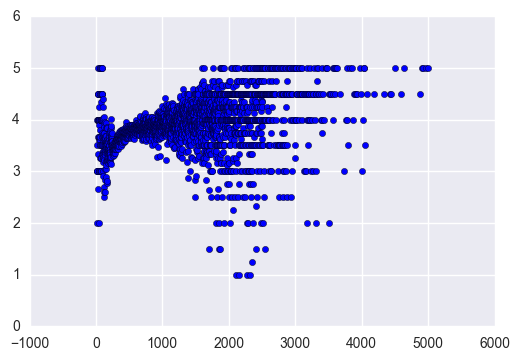

In [43]:
plt.scatter(x.index, x.values)

In [67]:
len(df.profile_name.value_counts())

100

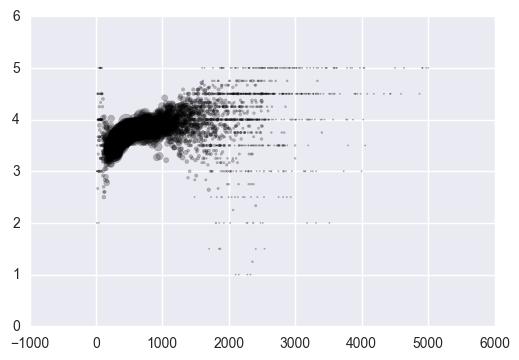

In [63]:
x = df.groupby(df.text.str.len()).review_overall.agg(['mean', 'count'])
plt.scatter(x.index, x['mean'], s=x['count'], color='k', alpha=.25)

In [ ]:
# %load solutions/groupby_00.py
df.groupby(df.text.str.len()).review_overall.mean().plot(style='k.')


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Find the relationship between review length (number of **words** and average `reveiw_overall`.

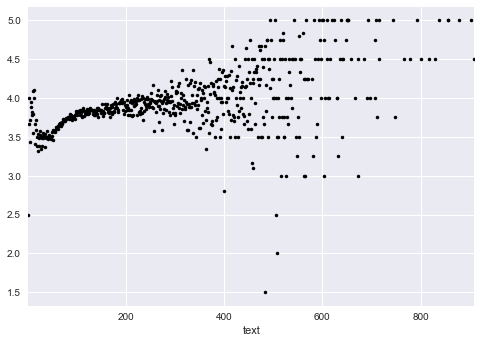

In [202]:
# %load solutions/groupby_00b.py
(df.groupby(df.text.str.count('\w+'))
   .review_overall
   .mean().plot(style='k.'))


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Find the relationship between the number of reviews for a beer and the average `review_overall`.


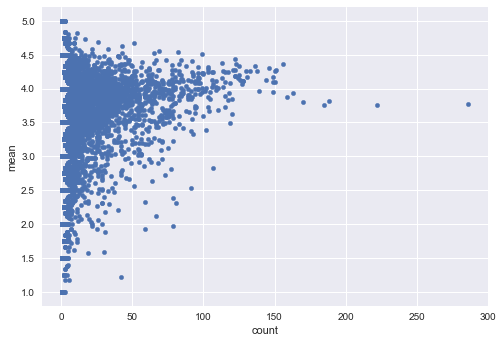

In [215]:
(df.groupby('beer_name').review_overall.agg(['mean', 'count'])
   .plot.scatter(x="count", y="mean"))

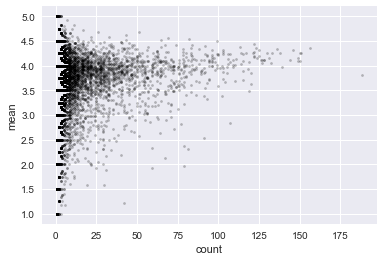

In [84]:
%load solutions/groupby_01.py

# Transform

This is what to use when

- You have a groupwise calculation, but
- The output should be the same shape as the input

For example, suppose we wanted to normalize each reviewer's scores by their average score. 

In [70]:
# Define demean(v: array) -> array
def demean(v):
    return v - v.mean()

In [71]:
v = np.arange(9)
demean(v)

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

Just calling `demean` on the entire Series will noramilze by the *global* average.

In [72]:
demean(df.review_overall)

0        0.245731
1        0.245731
2        0.745731
3        0.245731
4        0.245731
           ...   
76009    0.245731
76010    0.745731
76011    1.245731
76012    0.745731
76013   -0.254269
Name: review_overall, dtype: float64

If you're making a recommnedation system, you might want to normalize by each person's *individual* mean. A rating of 4 from someone's whose average is 2 is in some sense more meaningful that a 4 from someone who always gives 4s.

In [73]:
df[review_cols].head()

,review_appearance,review_aroma,review_overall,review_palate,review_taste
0,3.5,3.5,4.0,4.0,4.0
1,3.0,4.0,4.0,4.5,4.5
2,4.5,4.0,4.5,4.0,4.5
3,3.0,2.5,4.0,3.5,3.5
4,3.5,3.5,4.0,3.5,4.0


In [74]:
df[review_cols].shape

(76014, 5)

In [77]:
normalized = df.groupby("profile_name")[review_cols].transform(demean)
normalized.head()

,review_appearance,review_aroma,review_overall,review_palate,review_taste
0,-0.122437,0.003016,0.231604,0.389023,0.278649
1,-0.622437,0.503016,0.231604,0.889023,0.778649
2,0.755879,0.357983,0.710705,0.068379,0.758663
3,-0.622437,-0.996984,0.231604,-0.110977,-0.221351
4,-0.122437,0.003016,0.231604,-0.110977,0.278649


In [78]:
normalized.shape

(76014, 5)

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Do reviewer's `review_overall` trend over a person's time reviewing?

Hint: Need an indictor that tracks which review this is for that person.

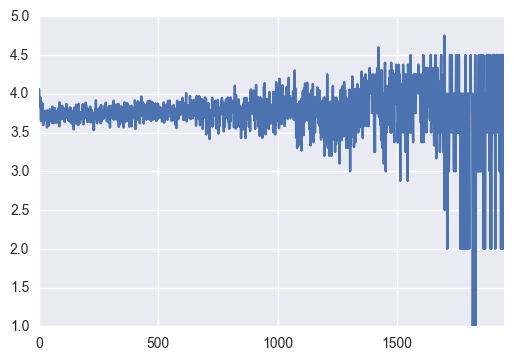

In [79]:
# %load solutions/groupby_02.py
order = df.groupby("profile_name").review_overall.cumcount()
df.groupby(order).review_overall.mean().plot();